# Analyzing [Stack Overflow Annual Developer Surveys](https://insights.stackoverflow.com/survey).

In [1]:
import pandas as pd

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999

In [3]:
surveys = {
    "2011": {
        "data": "2011 Stack Overflow Survey Results/2011 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2012": {
        "data": "2012 Stack Overflow Survey Results/2012 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2013": {
        "data": "2013 Stack Overflow Survey Responses/2013 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2014": {
        "data": "2014 Stack Overflow Survey Responses/2014 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2015": {
        "data": "2015 Stack Overflow Developer Survey Responses/2015 Stack Overflow Developer Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2016": {
        "data": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv",
        "readme": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/READ_ME_-_The_Public_2016_Stack_Overflow_Developer_Survey_Results.txt",
        "schema": None
    },
    "2017": {
        "data": "developer_survey_2017/survey_results_public.csv",
        "readme": "developer_survey_2017/README_2017.txt",
        "schema": "developer_survey_2017/survey_results_schema.csv"
    },
    "2018": {
        "data": "developer_survey_2018/survey_results_public.csv",
        "readme": "developer_survey_2018/README_2018.txt",
        "schema": "developer_survey_2018/survey_results_schema.csv"
    },
    "2019": {
        "data": "developer_survey_2019/survey_results_public.csv",
        "readme": "developer_survey_2019/README_2019.txt",
        "schema": "developer_survey_2019/survey_results_schema.csv"
    },
    "2020": {
        "data": "developer_survey_2020/survey_results_public.csv",
        "readme": "developer_survey_2020/README_2020.txt",
        "schema": "developer_survey_2020/survey_results_schema.csv"
    }
}

In [4]:
def search_schema(df, string):
    """Searches schema's DataFrame columns 'Question' for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        DataFrame containing labels and questions with the matched word.
    """
    if 'Question' in df.columns:
        return df[df['Question'].str.contains('\W*'+string+'\W*', case=False, regex=True)]
    return df[df['QuestionText'].str.contains('\W*'+string+'\W*', case=False, regex=True)]

def search_columns(df, string):
    """Searches DataFrame's columns for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        List containing all the columns with the word match.
    """
    return df.columns[df.columns.str.contains('\W*'+string+'\W*', case=False, regex=True)].tolist()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)
survey_2017.shape

(51392, 154)

In [7]:
intervals = [i for i in range(10000, 100001, 10000)] + [i for i in range(120000, 200001, 20000)]

def process_salary(df):
    dataframe = df.copy()
    dataframe = dataframe.dropna(subset=['Salary'], axis=0)
    dataframe['Salary'] = dataframe['Salary'].apply(lambda x: intervals[np.argmin(abs(np.array(intervals) - x))])
    return dataframe

def process_overpaid(df):
    dataframe = df.copy()
    dataframe['Overpaid'] = dataframe['Overpaid'].fillna('Unknown')
    return dataframe

def make_dummies(df, col, prefix):
    dataframe = pd.get_dummies(df, columns=[col], prefix=prefix)
    return dataframe

survey_2017_clean = survey_2017.copy()
survey_2017_clean = process_salary(survey_2017_clean)
survey_2017_clean = process_overpaid(survey_2017_clean)
overpaid_list = ['Overpaid_'+i for i in survey_2017_clean['Overpaid'].unique()]
survey_2017_clean = make_dummies(survey_2017_clean, 'Overpaid', 'Overpaid')

In [8]:
set(survey_2017_clean.columns).difference(set(survey_2017))

{'Overpaid_Greatly overpaid',
 'Overpaid_Greatly underpaid',
 'Overpaid_Neither underpaid nor overpaid',
 'Overpaid_Somewhat overpaid',
 'Overpaid_Somewhat underpaid',
 'Overpaid_Unknown'}

In [9]:
overpaid_dict = {
    "Overpaid_Greatly underpaid": "Greatly underpaid",
    "Overpaid_Somewhat underpaid": "Somewhat underpaid",
    "Overpaid_Neither underpaid nor overpaid": "Neither",
    "Overpaid_Somewhat overpaid": "Somewhat overpaid",
    "Overpaid_Greatly overpaid": "Greatly overpaid",
    "Overpaid_Unknown": "Not sure",
}

In [10]:
salary_overpaid_2017 = survey_2017_clean[['Salary']+overpaid_list].groupby(by='Salary').sum()
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Unknown,Overpaid_Greatly overpaid
Salary,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0
20000,295.0,466.0,43.0,156.0,1.0,10.0
30000,356.0,590.0,71.0,193.0,4.0,5.0
40000,481.0,678.0,66.0,163.0,1.0,8.0
50000,534.0,721.0,62.0,164.0,2.0,7.0
60000,474.0,592.0,88.0,121.0,2.0,4.0
70000,334.0,435.0,57.0,68.0,1.0,1.0
80000,285.0,334.0,43.0,44.0,1.0,7.0
90000,265.0,271.0,55.0,31.0,1.0,3.0


In [11]:
salary_overpaid_2017['Total'] = salary_overpaid_2017.sum(axis=1)

In [12]:
def convert_xticks(arr):
    result = map(lambda x: str(x//1000)+'k', arr)
    return list(result)

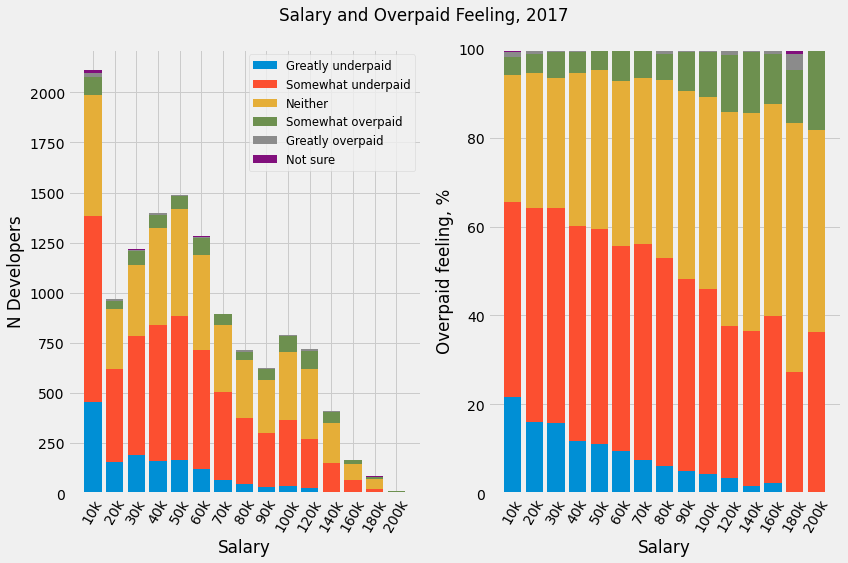

In [13]:
bottom = len(intervals) * [0]
ticks = np.arange(len(intervals))
labels = convert_xticks(intervals)

plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
for overpaid in overpaid_dict:
    axes[0].bar(ticks, salary_overpaid_2017[overpaid], bottom=bottom)
    bottom += salary_overpaid_2017[overpaid]
    
axes[0].set_xlabel('Salary')
axes[0].set_ylabel('N Developers')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels, rotation=60)
axes[0].legend(labels=overpaid_dict.values(), fontsize='small')

bottom = len(intervals) * [0]
for overpaid in overpaid_dict:
    row = salary_overpaid_2017[overpaid] * 100 / salary_overpaid_2017['Total']
    axes[1].bar(ticks, row, bottom=bottom)
    bottom += row
    
axes[1].set_xlabel('Salary')
axes[1].set_ylabel('Overpaid feeling, %')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels, rotation=60)
axes[1].legend([]).set_visible(False)

fig.suptitle('Salary and Overpaid Feeling, 2017')

fig.tight_layout()
plt.show()

In [14]:
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Unknown,Overpaid_Greatly overpaid,Total
Salary,,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0,2112.0
20000,295.0,466.0,43.0,156.0,1.0,10.0,971.0
30000,356.0,590.0,71.0,193.0,4.0,5.0,1219.0
40000,481.0,678.0,66.0,163.0,1.0,8.0,1397.0
50000,534.0,721.0,62.0,164.0,2.0,7.0,1490.0
60000,474.0,592.0,88.0,121.0,2.0,4.0,1281.0
70000,334.0,435.0,57.0,68.0,1.0,1.0,896.0
80000,285.0,334.0,43.0,44.0,1.0,7.0,714.0
90000,265.0,271.0,55.0,31.0,1.0,3.0,626.0


In [15]:
def list_to_dummies(col, sep=";"):
    """Converts list values in the series to dummies df.
    Args:
      col (Pandas.Series): Column with lists, that will be separated and exploded.
      sep (str): Separator of the list values.
    Returns:
      Pandas.DataFrame with dummies from initial column list values.
    """
    split = col.str.split(sep)
    explode = split.explode()
    dummies = pd.get_dummies(explode)
    return dummies.sum(level=0)

def plot_pair(df, group, col_order):
    groupped = df.copy()
    groupped = groupped.groupby(by=group).sum().T
    groupped['Total'] = groupped.sum(axis=1)
    groupped = groupped.sort_values(by='Total', ascending=False)
    groupped[col_order].plot.barh(stacked=True, figsize=(15,10))

def plot_pair_pct(df, group, col_order):
    groupped = df.copy()
    groupped = groupped.groupby(by=group).sum().T
    groupped['Total'] = groupped.sum(axis=1)
    groupped_pct = groupped.apply(lambda x: x*100 / x['Total'], axis=1)
    groupped_pct['Satisfaction'] = groupped_pct[col_order[-2:]].sum(axis=1)
    groupped_pct = groupped_pct.sort_values(by='Satisfaction', ascending=False)
    groupped_pct[col_order].plot.barh(stacked=True, figsize=(15,20))

In [16]:
survey_2018 = pd.read_csv(surveys['2018']['data'], low_memory=False)
print(survey_2018.shape, survey_2018.columns.tolist())

(98855, 129) ['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 'LastNewJob', 'AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10', 'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1', 'JobContactPriorities2', 'JobContactPriorities3', 'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4', 'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7', 'UpdateCV', 'Currency', 'Salary', 'SalaryType', 'ConvertedSalary', 'CurrencySymbol', 'C

In [17]:
from itertools import chain

survey_2018_clean = survey_2018.copy()
survey_2018_clean = survey_2018_clean.dropna(subset=['LanguageWorkedWith'])

dummies = list_to_dummies(survey_2018_clean['LanguageWorkedWith'])
print(dummies.sum().sort_values(ascending=False))

survey_2018_ = pd.concat([survey_2018_clean[['JobSatisfaction', 'CareerSatisfaction']], dummies], axis=1)

JavaScript              54686
HTML                    53628
CSS                     50979
SQL                     44670
Java                    35521
Bash/Shell              31172
Python                  30359
C#                      26954
PHP                     24071
C++                     19872
C                       18042
TypeScript              13626
Ruby                     7911
Swift                    6310
Assembly                 5760
Go                       5532
Objective-C              5510
VB.NET                   5254
R                        4813
Matlab                   4564
VBA                      3810
Kotlin                   3508
Scala                    3420
Groovy                   3373
Perl                     3280
Visual Basic 6           3087
Lua                      2733
CoffeeScript             2603
Delphi/Object Pascal     2025
Haskell                  1961
Rust                     1857
F#                       1115
Clojure                  1032
Erlang    

In [18]:
search_schema(pd.read_csv(surveys['2018']['schema']), 'language')

,Column,QuestionText
20,AssessJob4,"Imagine that you are assessing a potential job opportunity. Please rank the following aspects of the job opportunity in order of importance (by dragging the choices up and down), where 1 is the most important and 10 is the least important. The languages, frameworks, and other technologies I'd be working with"
65,LanguageWorkedWith,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
66,LanguageDesireNextYear,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
92,AdsPriorities7,"Please rank the following advertising qualities in order of their importance to you (by dragging the choices up and down), where 1 is the most important, and 7 is the least important. The advertisement avoids fluffy or vague language"


In [19]:
search_schema(pd.read_csv(surveys['2018']['schema']), 'sat')

,Column,QuestionText
12,JobSatisfaction,"How satisfied are you with your current job? If you work more than one job, please answer regarding the one you spend the most hours on."
13,CareerSatisfaction,"Overall, how satisfied are you with your career thus far?"
21,AssessJob5,"Imagine that you are assessing a potential job opportunity. Please rank the following aspects of the job opportunity in order of importance (by dragging the choices up and down), where 1 is the most important and 10 is the least important. The compensation and benefits offered"
47,JobEmailPriorities5,"Imagine that same company decided to contact you through email. Please rank the following items by how important it is to include them in the message (by dragging the choices up and down), where 1 is the most important and 7 is the least important. An estimate of the compensation range"


In [20]:
language_job_satisfaction_2018 = survey_2018_.groupby(by='JobSatisfaction').sum().T
language_job_satisfaction_2018

JobSatisfaction,Extremely dissatisfied,Extremely satisfied,Moderately dissatisfied,Moderately satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied
Assembly,152.0,726.0,297.0,1360.0,296.0,350.0,509.0
Bash/Shell,819.0,5130.0,2259.0,9896.0,1628.0,2514.0,3430.0
C,452.0,2231.0,1052.0,4467.0,972.0,1227.0,1831.0
C#,729.0,3915.0,1956.0,8367.0,1522.0,2225.0,3222.0
C++,497.0,2520.0,1163.0,5206.0,1034.0,1376.0,2107.0
CSS,1341.0,7446.0,3621.0,15199.0,2855.0,4027.0,5859.0
Clojure,37.0,202.0,85.0,292.0,51.0,87.0,94.0
Cobol,28.0,79.0,36.0,141.0,44.0,49.0,64.0
CoffeeScript,70.0,466.0,182.0,808.0,159.0,198.0,292.0
Delphi/Object Pascal,77.0,283.0,144.0,567.0,128.0,154.0,242.0


In [21]:
language_career_satisfaction_2018 = survey_2018_.groupby(by='CareerSatisfaction').sum().T
language_career_satisfaction_2018

CareerSatisfaction,Extremely dissatisfied,Extremely satisfied,Moderately dissatisfied,Moderately satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied
Assembly,199.0,933.0,312.0,1534.0,455.0,398.0,748.0
Bash/Shell,793.0,5576.0,1794.0,10736.0,1979.0,2227.0,4681.0
C,553.0,2745.0,1012.0,4971.0,1466.0,1327.0,2509.0
C#,708.0,4488.0,1509.0,8866.0,1833.0,2004.0,4315.0
C++,562.0,3095.0,1121.0,5699.0,1625.0,1431.0,2825.0
CSS,1440.0,8642.0,2887.0,16375.0,3560.0,3744.0,7811.0
Clojure,42.0,213.0,57.0,327.0,62.0,80.0,134.0
Cobol,30.0,99.0,33.0,150.0,51.0,43.0,87.0
CoffeeScript,68.0,490.0,140.0,960.0,146.0,155.0,369.0
Delphi/Object Pascal,69.0,288.0,148.0,559.0,165.0,159.0,332.0


In [22]:
language_job_satisfaction_2018.columns.tolist()

['Extremely dissatisfied',
 'Extremely satisfied',
 'Moderately dissatisfied',
 'Moderately satisfied',
 'Neither satisfied nor dissatisfied',
 'Slightly dissatisfied',
 'Slightly satisfied']

In [23]:
columns_sorted_2018 = [
    'Extremely satisfied',
    'Moderately satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Moderately dissatisfied',
    'Extremely dissatisfied',
]
language_job_satisfaction_2018_ = language_job_satisfaction_2018[columns_sorted_2018].copy()

language_job_satisfaction_2018_['Total'] = language_job_satisfaction_2018_.sum(axis=1)
language_job_satisfaction_2018_['Satisfaction'] = language_job_satisfaction_2018_[columns_sorted_2018[:3]].sum(axis=1) / language_job_satisfaction_2018_['Total']
language_job_satisfaction_2018_['Dissatisfaction'] = language_job_satisfaction_2018_[columns_sorted_2018[-3:]].sum(axis=1) / language_job_satisfaction_2018_['Total']
language_job_satisfaction_2018_['Sat_Net'] = language_job_satisfaction_2018_['Satisfaction'] - language_job_satisfaction_2018_['Dissatisfaction']
language_job_satisfaction_2018_.sort_values(by='Total', ascending=False)

JobSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
JavaScript,8127.0,16744.0,6406.0,3052.0,4491.0,4012.0,1474.0,44306.0,0.705931,0.225184,0.480748
HTML,7781.0,15924.0,6104.0,2995.0,4244.0,3780.0,1416.0,42244.0,0.705639,0.223464,0.482175
CSS,7446.0,15199.0,5859.0,2855.0,4027.0,3621.0,1341.0,40348.0,0.706454,0.222787,0.483667
SQL,6595.0,13822.0,5247.0,2563.0,3739.0,3356.0,1231.0,36553.0,0.702104,0.227779,0.474325
Java,4619.0,10081.0,4095.0,1978.0,2852.0,2469.0,964.0,27058.0,0.694619,0.232279,0.462340
Bash/Shell,5130.0,9896.0,3430.0,1628.0,2514.0,2259.0,819.0,25676.0,0.718804,0.217791,0.501013
Python,4447.0,8740.0,3165.0,1550.0,2238.0,2032.0,755.0,22927.0,0.713220,0.219174,0.494046
C#,3915.0,8367.0,3222.0,1522.0,2225.0,1956.0,729.0,21936.0,0.706783,0.223833,0.482950
PHP,3312.0,6833.0,2842.0,1418.0,1851.0,1740.0,677.0,18673.0,0.695496,0.228565,0.466931
C++,2520.0,5206.0,2107.0,1034.0,1376.0,1163.0,497.0,13903.0,0.707257,0.218370,0.488887


In [24]:
language_career_satisfaction_2018_ = language_career_satisfaction_2018[columns_sorted_2018].copy()

language_career_satisfaction_2018_['Total'] = language_career_satisfaction_2018_.sum(axis=1)
language_career_satisfaction_2018_['Satisfaction'] = language_career_satisfaction_2018_[columns_sorted_2018[:3]].sum(axis=1) / language_career_satisfaction_2018_['Total']
language_career_satisfaction_2018_['Dissatisfaction'] = language_career_satisfaction_2018_[columns_sorted_2018[-3:]].sum(axis=1) / language_career_satisfaction_2018_['Total']
language_career_satisfaction_2018_['Sat_Net'] = language_career_satisfaction_2018_['Satisfaction'] - language_career_satisfaction_2018_['Dissatisfaction']
language_career_satisfaction_2018_.sort_values(by='Total', ascending=False)

CareerSatisfaction,Extremely satisfied,Moderately satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Moderately dissatisfied,Extremely dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
JavaScript,9313.0,17946.0,8507.0,3697.0,4021.0,3160.0,1504.0,48148.0,0.742835,0.180381,0.562453
HTML,9000.0,17163.0,8210.0,3754.0,3924.0,3024.0,1509.0,46584.0,0.737871,0.181543,0.556328
CSS,8642.0,16375.0,7811.0,3560.0,3744.0,2887.0,1440.0,44459.0,0.738388,0.181538,0.556850
SQL,7480.0,14726.0,7003.0,3032.0,3413.0,2577.0,1219.0,39450.0,0.740406,0.182738,0.557668
Java,5637.0,10907.0,5395.0,2630.0,2617.0,2054.0,1033.0,30273.0,0.724705,0.188419,0.536286
Bash/Shell,5576.0,10736.0,4681.0,1979.0,2227.0,1794.0,793.0,27786.0,0.755524,0.173253,0.582272
Python,5108.0,9546.0,4356.0,2158.0,2170.0,1657.0,801.0,25796.0,0.736936,0.179408,0.557528
C#,4488.0,8866.0,4315.0,1833.0,2004.0,1509.0,708.0,23723.0,0.744805,0.177929,0.566876
PHP,3940.0,7154.0,3781.0,1828.0,1814.0,1460.0,771.0,20748.0,0.716937,0.194959,0.521978
C++,3095.0,5699.0,2825.0,1625.0,1431.0,1121.0,562.0,16358.0,0.710295,0.190366,0.519929


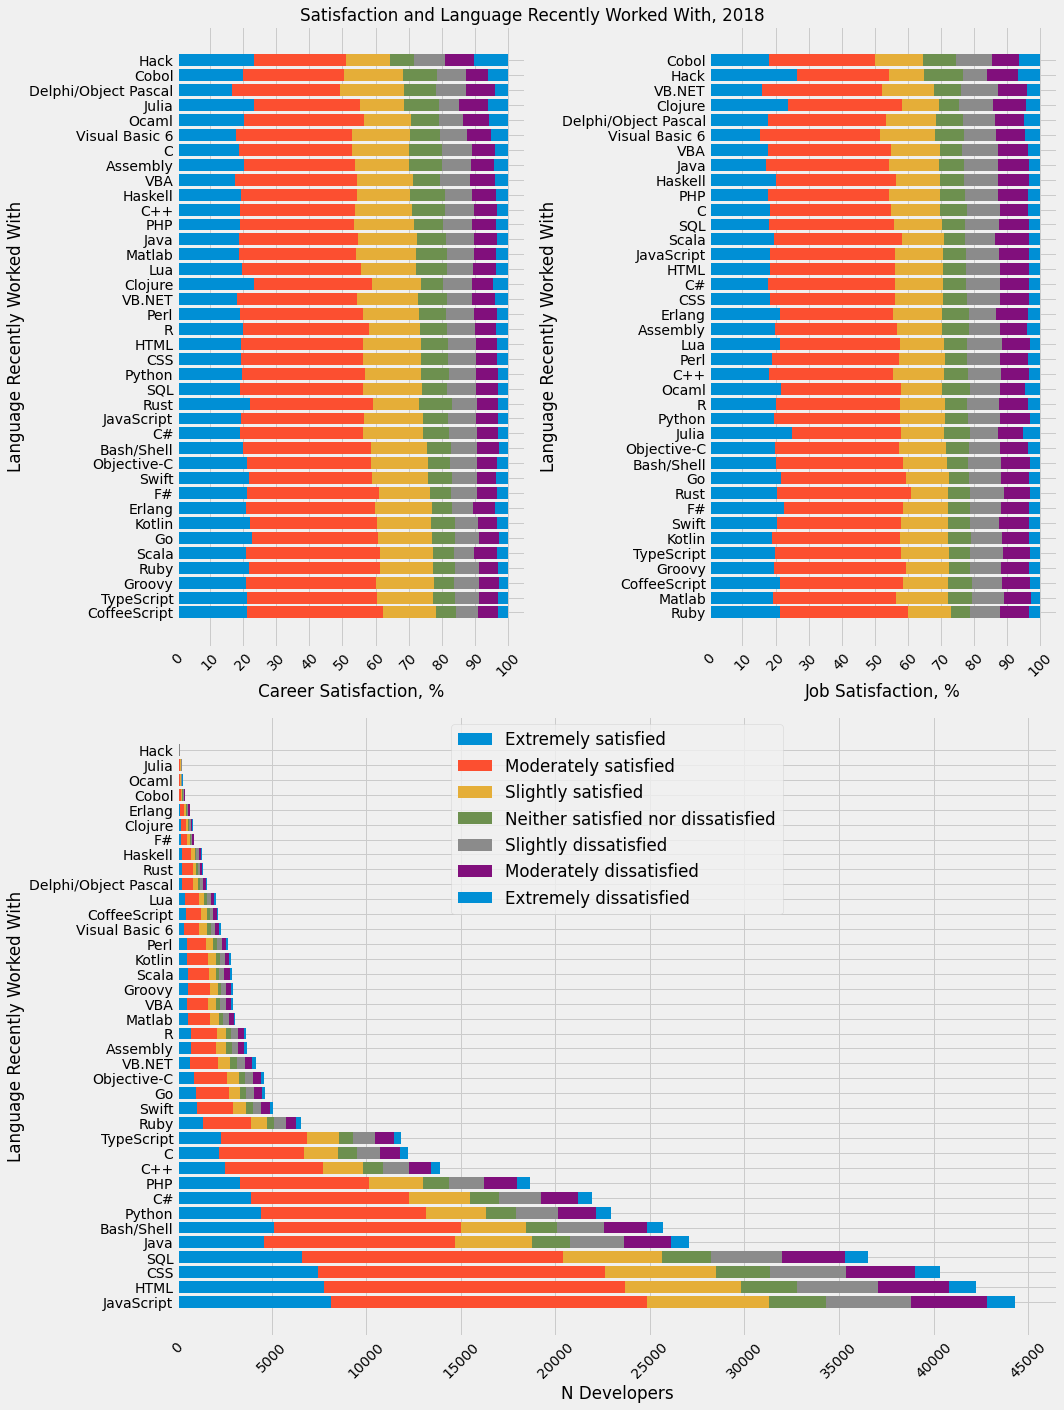

In [25]:
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

fig = plt.figure(figsize=(15, 20))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

lang_car_sat_2018_pct = language_career_satisfaction_2018_.copy()
lang_car_sat_2018_pct = lang_car_sat_2018_pct.sort_values(by='Sat_Net', ascending=False)

left = lang_car_sat_2018_pct.shape[0] * [0]
for column in columns_sorted_2018:
    row = lang_car_sat_2018_pct[column] * 100 / lang_car_sat_2018_pct['Total']
    ax1.barh(lang_car_sat_2018_pct.index.tolist(), row, left=left)
    left += row

ax1.set_xlabel('Career Satisfaction, %')
ax1.set_ylabel('Language Recently Worked With')
ax1.set_xticks([i for i in range(0, 101, 10)])
ax1.set_xticklabels([str(i) for i in range(0, 101, 10)])
ax1.tick_params(axis='x', labelrotation=45)
ax1.legend([]).set_visible(False)

lang_job_sat_2018_pct = language_job_satisfaction_2018_.copy()
lang_job_sat_2018_pct = lang_job_sat_2018_pct.sort_values(by='Sat_Net', ascending=False)

left = lang_job_sat_2018_pct.shape[0] * [0]
for column in columns_sorted_2018:
    row = lang_job_sat_2018_pct[column] * 100 / lang_job_sat_2018_pct['Total']
    ax2.barh(lang_job_sat_2018_pct.index.tolist(), row, left=left)
    left += row

ax2.set_xlabel('Job Satisfaction, %')
ax2.set_ylabel('Language Recently Worked With')
ax2.set_xticks([i for i in range(0, 101, 10)])
ax2.set_xticklabels([str(i) for i in range(0, 101, 10)])
ax2.tick_params(axis='x', labelrotation=45)
ax2.legend([]).set_visible(False)

lang_job_sat_2018 = language_job_satisfaction_2018_.copy()
lang_job_sat_2018 = lang_job_sat_2018.sort_values(by='Total', ascending=False)

left = lang_job_sat_2018.shape[0] * [0]
for column in columns_sorted_2018:
    ax3.barh(lang_job_sat_2018.index.tolist(), lang_job_sat_2018[column], left=left)
    left += lang_job_sat_2018[column]
    
ax3.set_xlabel('N Developers')
ax3.set_ylabel('Language Recently Worked With')
ax3.set_xticks([i for i in range(0, 45001, 5000)])
ax3.set_xticklabels([str(i) for i in range(0, 45001, 5000)])
ax3.tick_params(axis='x', labelrotation=45)
ax3.legend(labels=columns_sorted_2018, fontsize='large', loc='upper center')

fig.suptitle('Satisfaction and Language Recently Worked With, 2018')

fig.tight_layout()
plt.show()

In [26]:
survey_2019 = pd.read_csv(surveys['2019']['data'], low_memory=False)
print(survey_2019.shape, survey_2019.columns.tolist())

(88883, 85) ['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource', 'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz', 'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc', 'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev', 'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat', 'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith', 'DatabaseDesireNextYear', 'PlatformWorkedWith', 'PlatformDesireNextYear', 'WebFrameWorkedWith', 'WebFrameDesireNextYear', 'MiscTechWorkedWith', 'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers', 'BlockchainOrg', 'BlockchainIs', 'BetterLife', 'ITperson', 'OffOn', 'SocialMedia', 'Extraversion', 'ScreenName', 'SOVisit1st', 'SOVisitFr

In [27]:
survey_2019['LanguageWorkedWith'].value_counts()

HTML/CSS;JavaScript;PHP;SQL                                                      1483
C#;HTML/CSS;JavaScript;SQL                                                       1414
HTML/CSS;JavaScript                                                              1247
C#;HTML/CSS;JavaScript;SQL;TypeScript                                             990
Java                                                                              934
                                                                                 ... 
Bash/Shell/PowerShell;HTML/CSS;Java;Python;R;SQL;VBA                                1
Go;Java;JavaScript;Kotlin;Python;Rust                                               1
Bash/Shell/PowerShell;C;Clojure;Java;JavaScript;Scala;Other(s):                     1
C;JavaScript;Python;VBA;WebAssembly                                                 1
Bash/Shell/PowerShell;Dart;Go;HTML/CSS;Java;JavaScript;Python;Rust;TypeScript       1
Name: LanguageWorkedWith, Length: 20098, dtype: int64

In [28]:
survey_2019['CareerSat'].value_counts()

Very satisfied                        29173
Slightly satisfied                    25018
Slightly dissatisfied                  7670
Neither satisfied nor dissatisfied     7252
Very dissatisfied                      3734
Name: CareerSat, dtype: int64

In [29]:
survey_2019['JobSat'].value_counts()

Slightly satisfied                    24207
Very satisfied                        22452
Slightly dissatisfied                 10752
Neither satisfied nor dissatisfied     8720
Very dissatisfied                      4857
Name: JobSat, dtype: int64

In [45]:
columns_sorted_2019 = [
    'Very satisfied',
    'Slightly satisfied',
    'Neither satisfied nor dissatisfied',
    'Slightly dissatisfied',
    'Very dissatisfied',
]

In [46]:
survey_2019_clean = survey_2019.copy()
survey_2019_clean = survey_2019_clean.dropna(subset=['LanguageWorkedWith'])

dummies = list_to_dummies(survey_2019_clean['LanguageWorkedWith'])
print(dummies.sum().sort_values(ascending=False))

survey_2019_ = pd.concat([survey_2019_clean[['JobSat', 'CareerSat']], dummies], axis=1)

JavaScript               59219
HTML/CSS                 55466
SQL                      47544
Python                   36443
Java                     35917
Bash/Shell/PowerShell    31991
C#                       27097
PHP                      23030
C++                      20524
TypeScript               18523
C                        18017
Other(s):                 7920
Ruby                      7331
Go                        7201
Assembly                  5833
Swift                     5744
Kotlin                    5620
R                         5048
VBA                       4781
Objective-C               4191
Scala                     3309
Rust                      2794
Dart                      1683
Elixir                    1260
Clojure                   1254
WebAssembly               1015
F#                         973
Erlang                     777
dtype: int64


In [47]:
language_job_satisfaction_2019 = survey_2019_.groupby(by='JobSat').sum().T
language_job_satisfaction_2019

JobSat,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied,Very dissatisfied,Very satisfied
Assembly,469.0,498.0,1091.0,229.0,1142.0
Bash/Shell/PowerShell,2923.0,3899.0,9003.0,1675.0,9255.0
C,1604.0,1790.0,3978.0,791.0,3803.0
C#,2760.0,3463.0,7742.0,1526.0,7071.0
C++,1867.0,2062.0,4703.0,954.0,4551.0
Clojure,105.0,151.0,339.0,74.0,412.0
Dart,170.0,200.0,421.0,88.0,398.0
Elixir,122.0,145.0,359.0,87.0,384.0
Erlang,78.0,94.0,203.0,55.0,222.0
F#,95.0,120.0,240.0,58.0,281.0


In [48]:
language_career_satisfaction_2019 = survey_2019_.groupby(by='CareerSat').sum().T
language_career_satisfaction_2019

CareerSat,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied,Very dissatisfied,Very satisfied
Assembly,439.0,332.0,1105.0,227.0,1473.0
Bash/Shell/PowerShell,2373.0,2652.0,9256.0,1192.0,11848.0
C,1446.0,1357.0,4068.0,674.0,4884.0
C#,2249.0,2357.0,7811.0,1088.0,9522.0
C++,1657.0,1532.0,4863.0,766.0,5822.0
Clojure,92.0,95.0,335.0,35.0,550.0
Dart,144.0,129.0,390.0,77.0,571.0
Elixir,87.0,99.0,357.0,64.0,515.0
Erlang,61.0,70.0,206.0,35.0,302.0
F#,69.0,82.0,254.0,35.0,365.0


In [49]:
language_job_satisfaction_2019_ = language_job_satisfaction_2019[columns_sorted_2019].copy()

language_job_satisfaction_2019_['Total'] = language_job_satisfaction_2019_.sum(axis=1)
language_job_satisfaction_2019_['Satisfaction'] = language_job_satisfaction_2019_[columns_sorted_2019[:2]].sum(axis=1) / language_job_satisfaction_2019_['Total']
language_job_satisfaction_2019_['Dissatisfaction'] = language_job_satisfaction_2019_[columns_sorted_2019[-2:]].sum(axis=1) / language_job_satisfaction_2019_['Total']
language_job_satisfaction_2019_['Sat_Net'] = language_job_satisfaction_2019_['Satisfaction'] - language_job_satisfaction_2019_['Dissatisfaction']
language_job_satisfaction_2019_.sort_values(by='Total', ascending=False)

JobSat,Very satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Very dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
JavaScript,15554.0,16833.0,6019.0,7410.0,3335.0,49151.0,0.658929,0.218612,0.440317
HTML/CSS,14093.0,15261.0,5415.0,6641.0,2983.0,44393.0,0.661230,0.216791,0.444439
SQL,12428.0,13776.0,4859.0,6123.0,2706.0,39892.0,0.656874,0.221323,0.435551
Python,9220.0,9389.0,3234.0,4039.0,1744.0,27626.0,0.673605,0.209332,0.464273
Java,8238.0,9478.0,3715.0,4181.0,1890.0,27502.0,0.644171,0.220748,0.423424
Bash/Shell/PowerShell,9255.0,9003.0,2923.0,3899.0,1675.0,26755.0,0.682415,0.208335,0.474080
C#,7071.0,7742.0,2760.0,3463.0,1526.0,22562.0,0.656546,0.221124,0.435422
PHP,5341.0,6194.0,2519.0,2773.0,1287.0,18114.0,0.636800,0.224136,0.412664
TypeScript,5577.0,5704.0,1972.0,2346.0,1108.0,16707.0,0.675226,0.206740,0.468486
C++,4551.0,4703.0,1867.0,2062.0,954.0,14137.0,0.654594,0.213341,0.441253


In [50]:
language_career_satisfaction_2019_ = language_career_satisfaction_2019[columns_sorted_2019].copy()

language_career_satisfaction_2019_['Total'] = language_career_satisfaction_2019_.sum(axis=1)
language_career_satisfaction_2019_['Satisfaction'] = language_career_satisfaction_2019_[columns_sorted_2019[:2]].sum(axis=1) / language_career_satisfaction_2019_['Total']
language_career_satisfaction_2019_['Dissatisfaction'] = language_career_satisfaction_2019_[columns_sorted_2019[-2:]].sum(axis=1) / language_career_satisfaction_2019_['Total']
language_career_satisfaction_2019_['Sat_Net'] = language_career_satisfaction_2019_['Satisfaction'] - language_career_satisfaction_2019_['Dissatisfaction']
language_career_satisfaction_2019_.sort_values(by='Total', ascending=False)

CareerSat,Very satisfied,Slightly satisfied,Neither satisfied nor dissatisfied,Slightly dissatisfied,Very dissatisfied,Total,Satisfaction,Dissatisfaction,Sat_Net
JavaScript,20601.0,17155.0,4919.0,5120.0,2553.0,50348.0,0.749901,0.152399,0.597501
HTML/CSS,18623.0,15489.0,4478.0,4617.0,2341.0,45548.0,0.748924,0.152762,0.596162
SQL,16466.0,14083.0,4021.0,4250.0,2022.0,40842.0,0.747980,0.153567,0.594413
Python,11697.0,9722.0,2769.0,2901.0,1302.0,28391.0,0.754429,0.148040,0.606389
Java,11079.0,9793.0,2918.0,2992.0,1470.0,28252.0,0.738780,0.157936,0.580844
Bash/Shell/PowerShell,11848.0,9256.0,2373.0,2652.0,1192.0,27321.0,0.772446,0.140698,0.631748
C#,9522.0,7811.0,2249.0,2357.0,1088.0,23027.0,0.752725,0.149607,0.603118
PHP,7020.0,6460.0,2059.0,2004.0,1095.0,18638.0,0.723254,0.166273,0.556980
TypeScript,7572.0,5596.0,1398.0,1617.0,837.0,17020.0,0.773678,0.144183,0.629495
C++,5822.0,4863.0,1657.0,1532.0,766.0,14640.0,0.729850,0.156967,0.572883


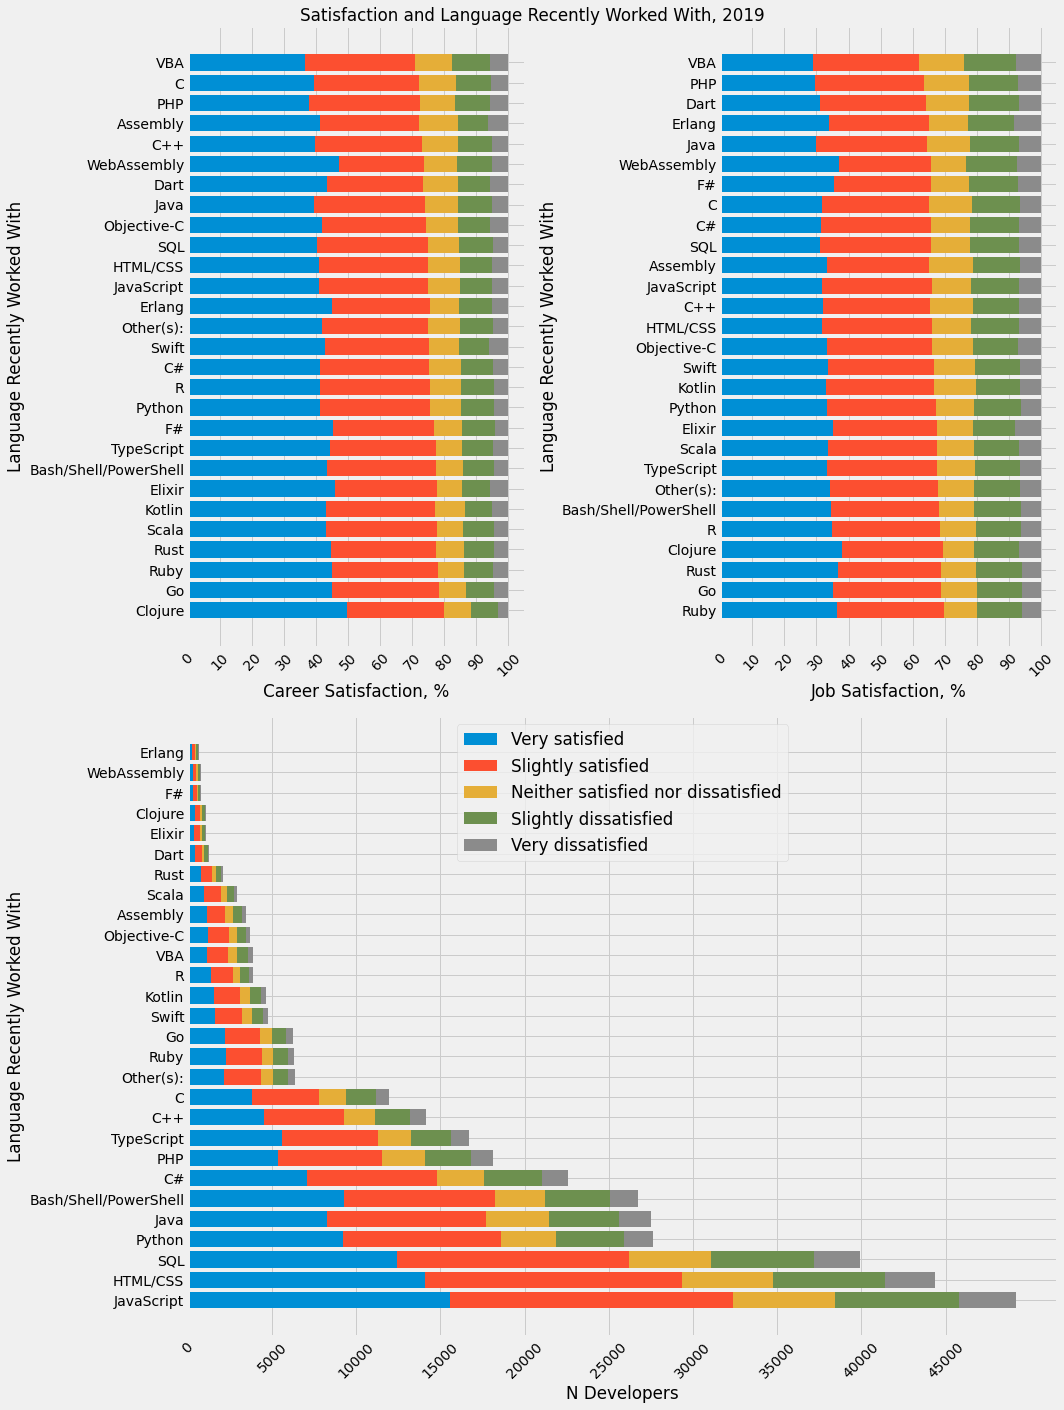

In [51]:
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

fig = plt.figure(figsize=(15, 20))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

lang_car_sat_2019_pct = language_career_satisfaction_2019_.copy()
lang_car_sat_2019_pct = lang_car_sat_2019_pct.sort_values(by='Sat_Net', ascending=False)

left = lang_car_sat_2019_pct.shape[0] * [0]
for column in columns_sorted_2019:
    row = lang_car_sat_2019_pct[column] * 100 / lang_car_sat_2019_pct['Total']
    ax1.barh(lang_car_sat_2019_pct.index.tolist(), row, left=left)
    left += row

ax1.set_xlabel('Career Satisfaction, %')
ax1.set_ylabel('Language Recently Worked With')
ax1.set_xticks([i for i in range(0, 101, 10)])
ax1.set_xticklabels([str(i) for i in range(0, 101, 10)])
ax1.tick_params(axis='x', labelrotation=45)
ax1.legend([]).set_visible(False)

lang_job_sat_2019_pct = language_job_satisfaction_2019_.copy()
lang_job_sat_2019_pct = lang_job_sat_2019_pct.sort_values(by='Sat_Net', ascending=False)

left = lang_job_sat_2019_pct.shape[0] * [0]
for column in columns_sorted_2019:
    row = lang_job_sat_2019_pct[column] * 100 / lang_job_sat_2019_pct['Total']
    ax2.barh(lang_job_sat_2019_pct.index.tolist(), row, left=left)
    left += row

ax2.set_xlabel('Job Satisfaction, %')
ax2.set_ylabel('Language Recently Worked With')
ax2.set_xticks([i for i in range(0, 101, 10)])
ax2.set_xticklabels([str(i) for i in range(0, 101, 10)])
ax2.tick_params(axis='x', labelrotation=45)
ax2.legend([]).set_visible(False)

lang_job_sat_2019 = language_job_satisfaction_2019_.copy()
lang_job_sat_2019 = lang_job_sat_2019.sort_values(by='Total', ascending=False)

left = lang_job_sat_2019.shape[0] * [0]
for column in columns_sorted_2019:
    ax3.barh(lang_job_sat_2019.index.tolist(), lang_job_sat_2019[column], left=left)
    left += lang_job_sat_2019[column]
    
ax3.set_xlabel('N Developers')
ax3.set_ylabel('Language Recently Worked With')
ax3.set_xticks([i for i in range(0, 45001, 5000)])
ax3.set_xticklabels([str(i) for i in range(0, 45001, 5000)])
ax3.tick_params(axis='x', labelrotation=45)
ax3.legend(labels=columns_sorted_2019, fontsize='large', loc='upper center')

fig.suptitle('Satisfaction and Language Recently Worked With, 2019')

fig.tight_layout()
plt.show()

In [58]:
survey_2020 = pd.read_csv(surveys['2020']['data'], low_memory=False)
print(survey_2020.shape, survey_2020.columns.tolist())

(64461, 61) ['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']


In [63]:
columns_sorted_2020 = columns_sorted_2020.copy()

survey_2020_clean = survey_2020.copy()
survey_2020_clean = survey_2020_clean.dropna(subset=['LanguageWorkedWith'])

dummies = list_to_dummies(survey_2020_clean['LanguageWorkedWith'])
print(dummies.sum().sort_values(ascending=False))

survey_2020_ = pd.concat([survey_2020_clean['JobSat'], dummies], axis=1)

language_job_satisfaction_2020 = survey_2020_.groupby(by='JobSat').sum().T
# language_career_satisfaction_2020 = survey_2020_.groupby(by='CareerSat').sum().T

language_job_satisfaction_2020_ = language_job_satisfaction_2020[columns_sorted_2020].copy()

language_job_satisfaction_2020_['Total'] = language_job_satisfaction_2020_.sum(axis=1)
language_job_satisfaction_2020_['Satisfaction'] = language_job_satisfaction_2020_[columns_sorted_2020[:2]].sum(axis=1) / language_job_satisfaction_2020_['Total']
language_job_satisfaction_2020_['Dissatisfaction'] = language_job_satisfaction_2020_[columns_sorted_2020[-2:]].sum(axis=1) / language_job_satisfaction_2020_['Total']
language_job_satisfaction_2020_['Sat_Net'] = language_job_satisfaction_2020_['Satisfaction'] - language_job_satisfaction_2020_['Dissatisfaction']
# language_job_satisfaction_2020_.sort_values(by='Total', ascending=False)

# language_career_satisfaction_2020_ = language_career_satisfaction_2020[columns_sorted_2020].copy()

# language_career_satisfaction_2020_['Total'] = language_career_satisfaction_2020_.sum(axis=1)
# language_career_satisfaction_2020_['Satisfaction'] = language_career_satisfaction_2020_[columns_sorted_2020[:2]].sum(axis=1) / language_career_satisfaction_2020_['Total']
# language_career_satisfaction_2020_['Dissatisfaction'] = language_career_satisfaction_2020_[columns_sorted_2020[-2:]].sum(axis=1) / language_career_satisfaction_2020_['Total']
# language_career_satisfaction_2020_['Sat_Net'] = language_career_satisfaction_2020_['Satisfaction'] - language_career_satisfaction_2020_['Dissatisfaction']
# language_career_satisfaction_2020_.sort_values(by='Total', ascending=False)


JavaScript               38822
HTML/CSS                 36181
SQL                      31413
Python                   25287
Java                     23074
Bash/Shell/PowerShell    18980
C#                       18041
PHP                      15007
TypeScript               14578
C++                      13707
C                        12487
Go                        5038
Kotlin                    4468
Ruby                      4046
Assembly                  3553
VBA                       3499
Swift                     3397
R                         3288
Rust                      2929
Objective-C               2340
Dart                      2280
Scala                     2052
Perl                      1796
Haskell                   1222
Julia                      519
dtype: int64


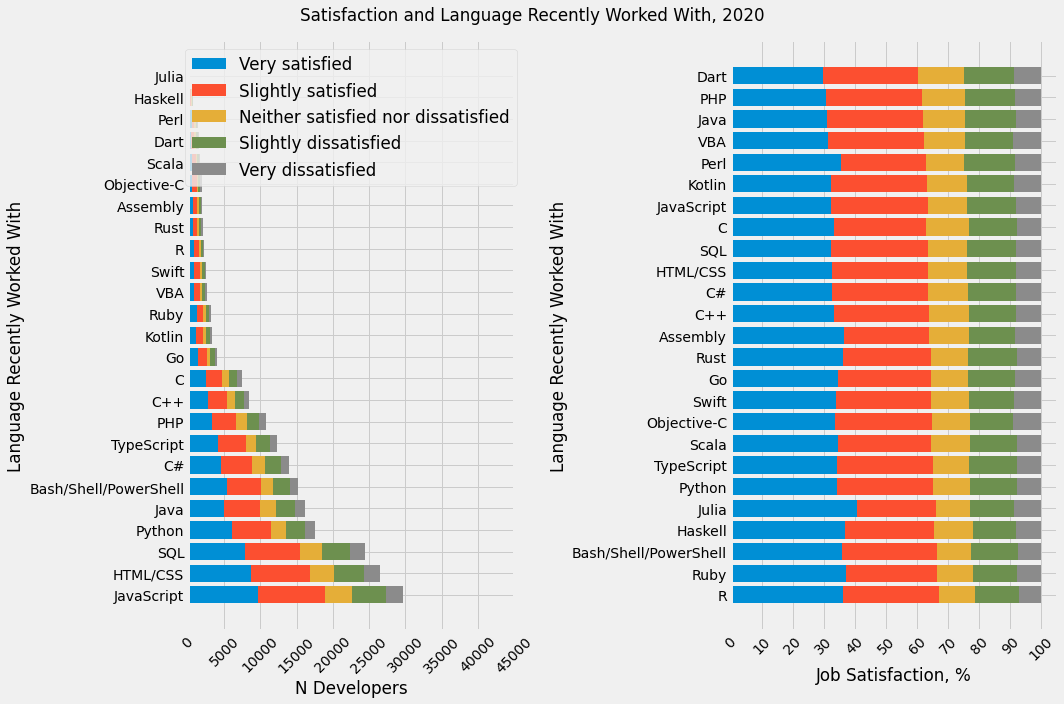

In [68]:
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

fig = plt.figure(figsize=(15, 10))

gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, :])

# lang_car_sat_2020_pct = language_career_satisfaction_2020_.copy()
# lang_car_sat_2020_pct = lang_car_sat_2020_pct.sort_values(by='Sat_Net', ascending=False)

# left = lang_car_sat_2020_pct.shape[0] * [0]
# for column in columns_sorted_2020:
#     row = lang_car_sat_2020_pct[column] * 100 / lang_car_sat_2020_pct['Total']
#     ax1.barh(lang_car_sat_2020_pct.index.tolist(), row, left=left)
#     left += row

# ax1.set_xlabel('Career Satisfaction, %')
# ax1.set_ylabel('Language Recently Worked With')
# ax1.set_xticks([i for i in range(0, 101, 10)])
# ax1.set_xticklabels([str(i) for i in range(0, 101, 10)])
# ax1.tick_params(axis='x', labelrotation=45)
# ax1.legend([]).set_visible(False)

lang_job_sat_2020 = language_job_satisfaction_2020_.copy()
lang_job_sat_2020 = lang_job_sat_2020.sort_values(by='Total', ascending=False)

left = lang_job_sat_2020.shape[0] * [0]
for column in columns_sorted_2020:
    ax1.barh(lang_job_sat_2020.index.tolist(), lang_job_sat_2020[column], left=left)
    left += lang_job_sat_2020[column]
    
ax1.set_xlabel('N Developers')
ax1.set_ylabel('Language Recently Worked With')
ax1.set_xticks([i for i in range(0, 45001, 5000)])
ax1.set_xticklabels([str(i) for i in range(0, 45001, 5000)])
ax1.tick_params(axis='x', labelrotation=45)
ax1.legend(labels=columns_sorted_2020, fontsize='large', loc='upper center')

lang_job_sat_2020_pct = language_job_satisfaction_2020_.copy()
lang_job_sat_2020_pct = lang_job_sat_2020_pct.sort_values(by='Sat_Net', ascending=False)

left = lang_job_sat_2020_pct.shape[0] * [0]
for column in columns_sorted_2020:
    row = lang_job_sat_2020_pct[column] * 100 / lang_job_sat_2020_pct['Total']
    ax2.barh(lang_job_sat_2020_pct.index.tolist(), row, left=left)
    left += row

ax2.set_xlabel('Job Satisfaction, %')
ax2.set_ylabel('Language Recently Worked With')
ax2.set_xticks([i for i in range(0, 101, 10)])
ax2.set_xticklabels([str(i) for i in range(0, 101, 10)])
ax2.tick_params(axis='x', labelrotation=45)
ax2.legend([]).set_visible(False)

fig.suptitle('Satisfaction and Language Recently Worked With, 2020')

fig.tight_layout()
plt.show()

In [65]:
search_schema(pd.read_csv(surveys['2020']['schema']), 'career')

,Column,QuestionText
29,NEWEdImpt,"How important is a formal education, such as a university degree in computer science, to your career?"
